In [105]:
import wandb
import pandas as pd
import matplotlib.pyplot as plt

In [140]:

# Initialize wandb API
api = wandb.Api()


Models = {"SiLIF":{'sweep_ids':["eae4d1oy", "tmr8nyog"]},
            "CadLIF":{'sweep_ids':["bikona4h", "1n49x8uc"]},
           "AdLIF":{'sweep_ids':["lhtw3v4i", "h0dh4ho9"]},
               "RF":{'sweep_ids':["ewl8ayrk", "3p2sflp1"]}}



sweep_params = ['lr', 'pdrop', 'n_hiddens', 'n_layers'] 
# 'scheduler_patience', 'scheduler_factor', 'dt_max', 'nb_hiddens', 'nb_layers', 'model_name']

In [141]:
# Function to retrieve all runs for a given sweep_id
def get_runs_from_sweep(sweep_id):
    sweep = api.sweep(f"maximes_crew/S3_SHD_runs/{sweep_id}")
    runs = sweep.runs
    data = []
    for run in runs:
        config = run.config
        summary = run.summary
        n_layers = config.get('nb_layers')
        n_hiddens = config.get('nb_hiddens')
        lr = config.get('lr')
        dt_min = config.get('dt_min')
        dt_max = config.get('dt_max')
        pdrop = config.get('pdrop')
        sched_patience = config.get('scheduler_patience')
        sched_factor = config.get('scheduler_factor')
        best_valid_acc = summary.get('best valid acc')

        if best_valid_acc is not None:
            data.append({
                'n_layers': n_layers,
                'n_hiddens': n_hiddens,
                'lr': lr,
                'dt_min': dt_min,
                'dt_max': dt_max,
                'pdrop' : pdrop,
                'scheduler_patience' : sched_patience,
                'scheduler_factor' : sched_factor,
                'best_valid_acc': best_valid_acc
            })
    return pd.DataFrame(data)

# Create a dictionary to hold dataframes for each model
hiddens_data = {}
layers_data = {}

# Loop over each model in the Models dictionary
for model_name, model_info in Models.items():
    sweeps = model_info['sweep_ids']
    # Create an empty list to store dataframes for each sweep
    dfs = []
    
    # For each sweep_id in the model's sweep_ids, retrieve the runs and store them in a list of dataframes

    df = get_runs_from_sweep(sweeps[0])
    if not df.empty:
        df['model_name'] = model_name  # Add the model name to the DataFrame
        hiddens_data[model_name] = df
    
    df = get_runs_from_sweep(sweeps[1])
    if not df.empty:
        df['model_name'] = model_name  # Add the model name to the DataFrame
        layers_data[model_name] = df
    # # Concatenate all dataframes for the current model
    # if dfs:
    #     Models[model_name]['dataframe'] = pd.concat(dfs, ignore_index=True)
    #     df['model_name'] = model_name  # Add the model name to the DataFrame
    #     all_model_data.append(df)

In [142]:
def convert_dict2DF(data):
    keys = list(data.keys())
    values = [data[key] for key in keys]

    # Add an empty string to single-level columns to convert them into a compatible MultiIndex format
    keys = [(key, '') if not isinstance(key, tuple) else key for key in keys]

    # Create a MultiIndex
    columns = pd.MultiIndex.from_tuples(keys)

    # Create a DataFrame with a single row (since this is a single set of parameters)
    df = pd.DataFrame([values], columns=columns)
    return df

In [143]:
adlif_ref = convert_dict2DF({'n_layers': 3,
  'n_hiddens': 128,
  'lr': 0.005,
  # 'dt_min': 0.01,
  # 'dt_max': 0.7,
  'pdrop': 0.25,
  # 'scheduler_patience': 10,
  # 'scheduler_factor': 0.7,
  ('best_valid_acc','mean'): 0.939812, 
  ('best_valid_acc','std'): 0.006328})

####
silif_ref = convert_dict2DF({'n_layers': 3,
  'n_hiddens': 128,
  'lr': 0.005,
  # 'dt_min': 0.01,
  # 'dt_max': 1.0,
  'pdrop': 0.25,
  # 'scheduler_patience': 10,
  # 'scheduler_factor': 0.7,
  ('best_valid_acc','mean'): 0.949700, 
  ('best_valid_acc','std'): 0.003868})

cadlif_ref = convert_dict2DF({'n_layers': 3,
  'n_hiddens': 128,
  'lr': 0.005,
  # 'dt_min': 0.01,
  # 'dt_max': 1.0,
  'pdrop': 0.1,
  # 'scheduler_patience': 10,
  # 'scheduler_factor': 0.7,
  ('best_valid_acc','mean'): 0.937216, 
  ('best_valid_acc','std'): 0.003962})

raf_ref = convert_dict2DF({'n_layers': 3,
  'n_hiddens': 128,
  'lr': 0.05,
  # 'dt_min': 0.01,
  # 'dt_max': 1.0,
  'pdrop': 0.1,
  # 'scheduler_patience': 10,
  # 'scheduler_factor': 0.7,
  ('best_valid_acc','mean'): 0.909983, 
  ('best_valid_acc','std'): 0.011744})  

ref_points = {'AdLIF': adlif_ref, 'CadLIF':cadlif_ref, 'SiLIF': silif_ref, 'RF': raf_ref}

In [144]:
ref_points

{'AdLIF':   n_layers n_hiddens     lr pdrop best_valid_acc          
                                             mean       std
 0        3       128  0.005  0.25       0.939812  0.006328,
 'CadLIF':   n_layers n_hiddens     lr pdrop best_valid_acc          
                                             mean       std
 0        3       128  0.005   0.1       0.937216  0.003962,
 'SiLIF':   n_layers n_hiddens     lr pdrop best_valid_acc          
                                             mean       std
 0        3       128  0.005  0.25         0.9497  0.003868,
 'RF':   n_layers n_hiddens    lr pdrop best_valid_acc          
                                            mean       std
 0        3       128  0.05   0.1       0.909983  0.011744}

In [168]:
X_axis = 'n_layers'
X_axis_name = 'Number of Layers'
data = layers_data

In [169]:
final_layers_data = {}

for model in data:

    # Convert the data to a DataFrame for easier manipulation
    df = data[model]

    # Group by n_layers and lr, then compute the mean of best_valid_acc for each group
    df_grouped = df.groupby(sweep_params).agg({'best_valid_acc': 'mean'}).reset_index()

    df_grouped = df.groupby(sweep_params).agg({'best_valid_acc': ['mean', 'std']}).reset_index()


    if model in ref_points:
        extra_point = ref_points[model]
        if pd.merge(df_grouped[sweep_params], extra_point[sweep_params], how='inner').empty:
            df_grouped = pd.concat([df_grouped,extra_point], ignore_index=True)

    df_grouped.columns = sweep_params + ['best_valid_acc_mean', 'best_valid_acc_std']


    # Now, group by n_layers and take the maximum of these averages
    idx = df_grouped.groupby(X_axis)['best_valid_acc_mean'].idxmax()
    df_final = df_grouped.loc[idx].reset_index(drop=True)

    df_final['upper_band'] = df_final['best_valid_acc_mean'] + df_final['best_valid_acc_std']/2
    df_final['lower_band'] = df_final['best_valid_acc_mean'] -  df_final['best_valid_acc_std']/2

    final_layers_data[model] = df_final

In [166]:
X_axis = 'n_hiddens'
X_axis_name = 'Number of hidden units'
data = hiddens_data

In [114]:
data['RF']

KeyError: 'RF'

In [136]:
final_data['RF']

,lr,pdrop,n_hiddens,n_layers,best_valid_acc_mean,best_valid_acc_std,upper_band,lower_band
0,0.05,0.1,64,3,0.906526,0.007499,0.910276,0.902776
1,0.05,0.1,128,3,0.909983,0.011744,0.915855,0.904111
2,0.05,0.1,256,3,0.913068,0.009363,0.917750,0.908387
3,0.05,0.1,512,3,0.920691,0.008967,0.925175,0.916208
4,0.05,0.1,1024,3,0.913076,0.001639,0.913895,0.912257
5,0.05,0.1,2048,3,0.916106,0.006390,0.919301,0.912912


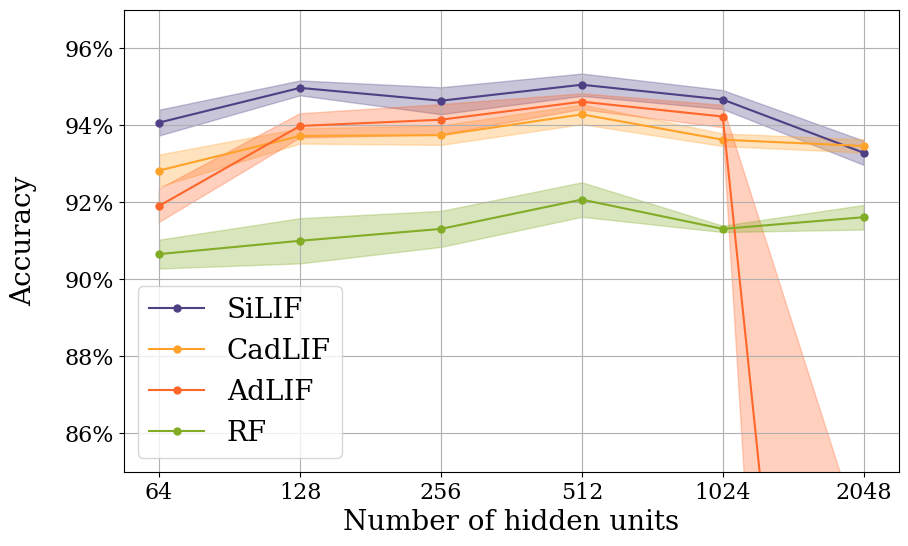

In [167]:
colors = {'AdLIF':'#FF662A', 
'CadLIF':'#FFA22A', 
'RF':'#82AC26', 
'SiLIF':'#4F3F84'}

fontsize=20
labelsize = 16

# plt.rcParams['text.usetex'] = False  # Use Matplotlib's built-in math text rendering
# plt.rcParams['font.family'] = 'serif'  # Use a serif font to emulate LaTeX style


# Plotting the Hidden Units Results
plt.figure(figsize=(10, 6))
for i, model in enumerate(final_data):
    df_final = final_data[model]
    x_values = range(len(df_final[X_axis]))
    plt.plot(x_values, df_final['best_valid_acc_mean'], marker='o', markersize=5, color=colors[model] , label=model)
    plt.fill_between(x_values, df_final['lower_band'], df_final['upper_band'], color=colors[model], alpha=0.3)



plt.xticks(ticks=x_values, labels=df_final[X_axis], fontsize=labelsize)

plt.ylim(0.85, 0.97)

# Increase size of tick labels
plt.tick_params(axis='both', which='major', labelsize=labelsize)

plt.xlabel(X_axis_name, fontsize=fontsize)
plt.ylabel('Accuracy', fontsize=fontsize, labelpad=20)

plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y))) #  if (y*100) % 10 in [0, 4, 8] else ''))

# plt.title('LIFcomplex vs RadLIF comparison over Hidden Units')
plt.grid(True)
plt.legend(fontsize=fontsize)

# plt.tight_layout()

plt.savefig("hiddens_sweep.pdf", format='pdf', bbox_inches='tight')  # Save as PDF with tight bounding box

plt.show()

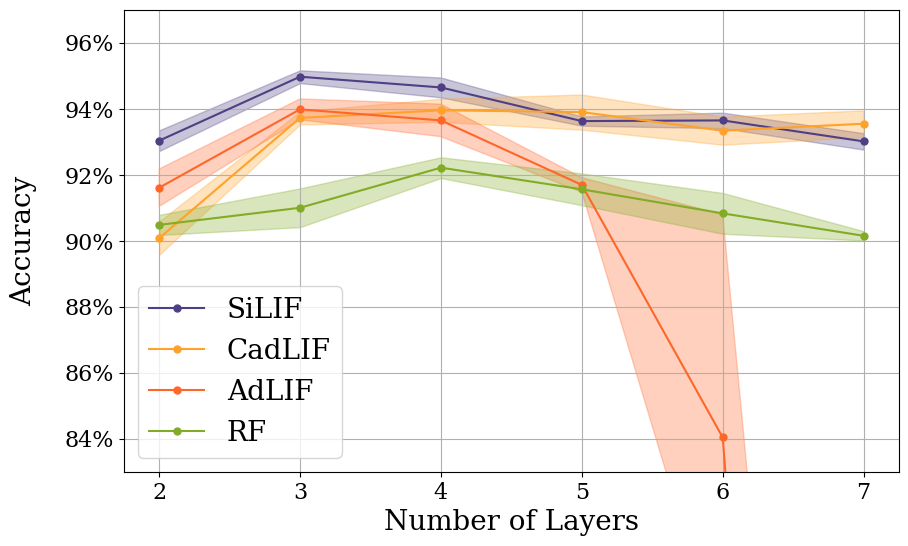

In [175]:
colors = {'AdLIF':'#FF662A', 
'CadLIF':'#FFA22A', 
'RF':'#82AC26', 
'SiLIF':'#4F3F84'}

fontsize=20
labelsize = 16

# plt.rcParams['text.usetex'] = False  # Use Matplotlib's built-in math text rendering
# plt.rcParams['font.family'] = 'serif'  # Use a serif font to emulate LaTeX style


# Plotting the Hidden Units Results
plt.figure(figsize=(10, 6))
for i, model in enumerate(final_data):
    df_final = final_data[model]
    x_values = range(len(df_final[X_axis]))
    plt.plot(x_values, df_final['best_valid_acc_mean'], marker='o', markersize=5, color=colors[model] , label=model)
    plt.fill_between(x_values, df_final['lower_band'], df_final['upper_band'], color=colors[model], alpha=0.3)



plt.xticks(ticks=x_values, labels=df_final[X_axis], fontsize=labelsize)

plt.ylim(0.83, 0.97)

# Increase size of tick labels
plt.tick_params(axis='both', which='major', labelsize=labelsize)

plt.xlabel(X_axis_name, fontsize=fontsize)
plt.ylabel('Accuracy', fontsize=fontsize, labelpad=20)

plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y))) #  if (y*100) % 10 in [0, 4, 8] else ''))

# plt.title('LIFcomplex vs RadLIF comparison over Hidden Units')
plt.grid(True)
plt.legend(fontsize=fontsize)

# plt.tight_layout()

plt.savefig("depth_sweep.pdf", format='pdf', bbox_inches='tight')  # Save as PDF with tight bounding box

plt.show()

In [156]:
model_order = list(Models.keys())

# Convert the 'model_name' column to a categorical type with the specified order
best_runs['model_name_'] = pd.Categorical(best_runs['model_name_'], categories=model_order, ordered=True)

# Sort best_runs based on the categorical model_name_ column to enforce the desired order
best_runs_sorted = best_runs.sort_values('model_name_').reset_index(drop=True)


NameError: name 'best_runs' is not defined

/tmp/ipykernel_2035046/555975499.py:18: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.errorbar(


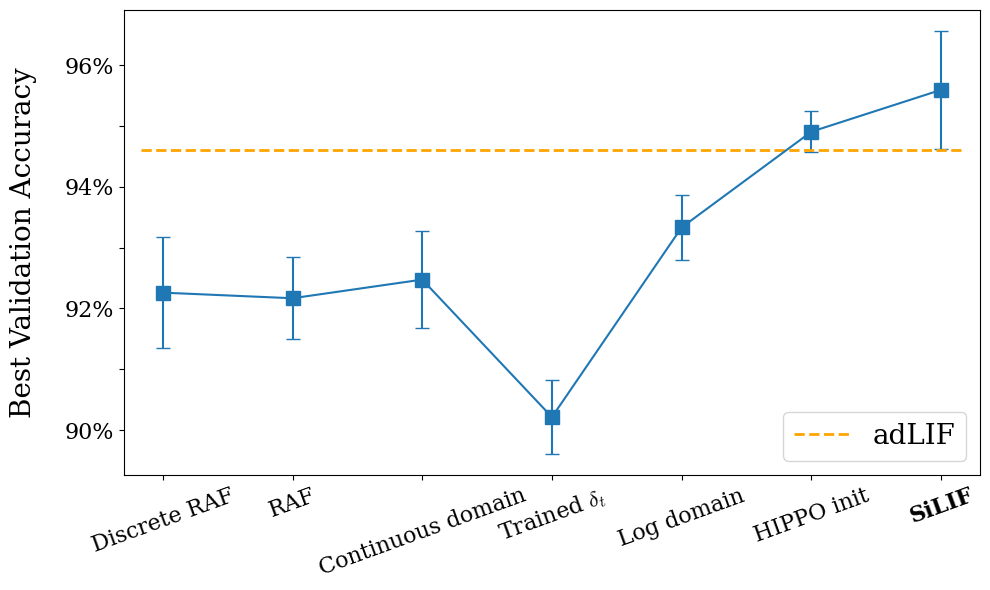

In [248]:
import numpy as np

fontsize=20
labelsize = 16

plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['text.usetex'] = False  # Use Matplotlib's built-in math text rendering
plt.rcParams['font.family'] = 'serif'  # Use a serif font to emulate LaTeX style


# Define the x positions for the model names
x_values = np.arange(len(best_runs_sorted['model_name_']))

# Plotting mean and std deviation in the order of the model names
plt.figure(figsize=(10, 6))

# Errorbar plot
plt.errorbar(
    best_runs_sorted['model_name_'], 
    best_runs_sorted['best_valid_acc_mean'], 
    yerr=best_runs_sorted['best_valid_acc_std'], 
    fmt='o', capsize=5, linestyle='-', marker='s',markersize=10,
)


x_min, x_max = plt.xlim()
# Add the orange dashed line for the adLIF model but with space on both ends
plt.plot([0.02, 0.98], [0.9461, 0.9461], 'orange', linestyle='--', label='adLIF', transform=plt.gca().get_yaxis_transform(), linewidth=2)

# Rotate x-ticks and set alignment
plt.xticks(rotation=20, ha='center', fontsize=labelsize)

# Set axis labels and title with increased font size
plt.ylabel('Best Validation Accuracy', fontsize=fontsize, labelpad=20)
# plt.title('Mean and Standard Deviation of Best Validation Accuracy for Each Model', fontsize=16)

# Set y-axis labels as percentages and only show even numbers
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y) if (y*100) % 2 == 0 else ''))

# Increase size of tick labels
plt.tick_params(axis='both', which='major', labelsize=labelsize)

labels = plt.gca().get_xticklabels()
for label in labels:
    if label.get_text() == 'SiLIF':
        label.set_fontweight('bold')  # Make ComplexLIF label bold

# Add a legend for the adLIF line
plt.legend(loc='lower right', fontsize=fontsize)

# Adjust layout to fit everything
plt.tight_layout()

plt.savefig("plot_vectorial.pdf", format='pdf', bbox_inches='tight')  # Save as PDF with tight bounding box

# Show the plot
plt.show()